# Generalized Roy Model

> **Reference:** *Causal Inference: The Mixtape*, Chapter 4 and Heckman & Vytlacil (2007)

This lecture introduces **essential heterogeneity**—the concept that treatment effects vary across individuals, and that selection into treatment may be correlated with these heterogeneous effects. We apply these concepts using the Online Retail Simulator to demonstrate why naive comparisons fail and how to properly decompose the bias.

---

## Part I: Theory

This section covers the theoretical foundations of heterogeneous treatment effects and the generalized Roy model framework.

## 1. The Potential Outcomes Framework

Recall from Lecture 01 the fundamental setup:

**Potential Outcomes**

$$
\begin{align*}
Y_i^1 &= \text{Outcome if treated} \\
Y_i^0 &= \text{Outcome if not treated}
\end{align*}
$$

**Treatment Effect for Individual $i$**

$$
\delta_i = Y_i^1 - Y_i^0
$$

**Observed Outcome (Switching Equation)**

$$
Y_i = D_i \cdot Y_i^1 + (1-D_i) \cdot Y_i^0
$$

### The Evaluation Problem

We can never observe both $Y_i^1$ and $Y_i^0$ for the same individual. This is the **fundamental problem of causal inference**. We must rely on comparing groups, which leads us to average treatment effects.

## 2. Heterogeneity in Treatment Effects

A central question in policy evaluation:

> *What gives rise to variation in outcomes among otherwise identical agents?* (Heckman, 2001)

**Answer: Heterogeneity**

Treatment effects can be decomposed:

$$
\delta_i = Y_i^1 - Y_i^0 = \underbrace{\bar{\delta}(X_i)}_{\text{average effect}} + \underbrace{\epsilon_i}_{\text{individual deviation}}
$$

### Types of Heterogeneity

| Type | Description | Can We Control? |
|------|-------------|-----------------|
| **Observable** | Differences in $X_i$ lead to different effects | Yes, condition on $X$ |
| **Unobservable** | Differences in $\epsilon_i$ (unknown to researcher) | Problematic if correlated with $D$ |

### When Does Heterogeneity Cause Bias?

Unobservable heterogeneity becomes problematic when **selection into treatment depends on the individual-specific gain** $\delta_i$.

## 3. Essential Heterogeneity

**Definition:** Essential heterogeneity occurs when:

1. Treatment effects are heterogeneous across individuals
2. Individuals select into treatment based on (at least partial) knowledge of their own effects
3. The selection mechanism is correlated with the treatment response

### Mathematical Formulation

Essential heterogeneity implies:

$$
\text{Cov}(D_i, \delta_i) \neq 0
$$

In words: Who gets treated is related to how much they would benefit.

### Consequences for Treatment Parameters

Under essential heterogeneity, the standard treatment parameters **diverge**:

$$
\text{ATE} \neq \text{ATT} \neq \text{ATC}
$$

Where:
- **ATE** = Average Treatment Effect = $E[\delta_i]$
- **ATT** = Average Treatment on Treated = $E[\delta_i | D_i = 1]$
- **ATC** = Average Treatment on Control = $E[\delta_i | D_i = 0]$

## 4. Bias Decomposition

The naive comparison of treated vs. untreated outcomes can be decomposed:

$$
\underbrace{E[Y|D=1] - E[Y|D=0]}_{\text{Naive Estimate}} = \underbrace{E[\delta_i]}_{\text{ATE}} + \underbrace{E[Y_0|D=1] - E[Y_0|D=0]}_{\text{Baseline Bias}} + \underbrace{E[\delta|D=1] - E[\delta]}_{\text{Selection on Gains}}
$$

### Two Sources of Bias

| Bias Component | Meaning | Sign Interpretation |
|----------------|---------|--------------------|
| **Baseline Bias** | Treated and control differ in $Y_0$ | Positive if treated have higher baseline |
| **Selection on Gains** | Treated have different effects than average | Positive if treated benefit more |

### Important Insight

Even if we could eliminate baseline bias (e.g., through matching on observables), **selection on gains** would remain as a source of bias under essential heterogeneity. This is why understanding the selection mechanism is crucial.

## 5. The Marginal Treatment Effect (MTE)

The **Marginal Treatment Effect** (Björklund & Moffitt, 1987; Heckman & Vytlacil, 1999, 2005) is defined as:

$$
\text{MTE}(x, u_D) = E[Y_1 - Y_0 | X = x, U_D = u_D]
$$

where $U_D$ represents the unobserved resistance to treatment (normalized to uniform distribution).

### Interpretation

- **Low $U_D$**: Individuals most likely to select into treatment
- **High $U_D$**: Individuals least likely to select into treatment

The MTE shows how treatment effects vary with selection propensity:

| MTE Pattern | Meaning |
|-------------|--------|
| **Constant** | No essential heterogeneity (ATE = ATT = ATC) |
| **Decreasing** | Those most likely to be treated benefit most (positive selection on gains) |
| **Increasing** | Those most likely to be treated benefit least (negative selection on gains) |

### Unifying Framework

All standard treatment parameters can be expressed as weighted averages of the MTE:

$$
\Delta^j = \int_0^1 \omega_j(u_D) \cdot \text{MTE}(u_D) \, du_D \quad \text{for } j \in \{\text{ATE, ATT, ATC}\}
$$

---

## Part II: Application

We now apply these concepts using the Online Retail Simulator to demonstrate essential heterogeneity in a business context.

In [1]:
# Standard library
from operator import itemgetter

# Third-party packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Simulator
from online_retail_simulator import simulate, load_job_results

# Local imports
from support import (
    compute_treatment_effects,
    compute_bias_decomposition,
    compute_mte_by_quality,
    plot_mte_by_quality,
    plot_treatment_parameters,
    plot_bias_decomposition,
    plot_treatment_effects_distribution,
    plot_selection_mechanism,
    print_essential_heterogeneity_summary,
)

np.random.seed(42)

## 1. Business Context: Content Optimization Selection

An e-commerce company runs a content optimization program. The marketing team selects products for enhanced content based on **product quality**:

- **High-quality products** are prioritized for content optimization (they're the company's best products)
- **Effect heterogeneity**: High-quality products already sell well, so the marginal benefit of optimization is smaller

This creates **essential heterogeneity**:
- Treatment effects vary by quality (heterogeneity)
- Selection into treatment is based on quality, which correlates with the effect size

### Key Question

If we simply compare optimized vs. non-optimized products, what bias do we introduce?

## 2. Data Generation with the Online Retail Simulator

We use the simulator to create a realistic e-commerce dataset, then apply a quality-based selection mechanism to introduce essential heterogeneity.

In [2]:
# Display simulation configuration
!cat config_simulation.yaml

STORAGE:
  PATH: output

RULE:
  CHARACTERISTICS:
    FUNCTION: simulate_characteristics_rule_based
    PARAMS:
      num_products: 500
      seed: 42

  METRICS:
    FUNCTION: simulate_metrics_rule_based
    PARAMS:
      date_start: "2024-11-15"
      date_end: "2024-11-15"
      sale_prob: 0.7
      seed: 42

PRODUCT_DETAILS:
  FUNCTION: simulate_product_details_mock


In [3]:
# Run simulation to generate baseline data
job_info = simulate("config_simulation.yaml")
products, metrics = itemgetter("products", "metrics")(load_job_results(job_info))

print(f"Products: {len(products)}")
print(f"Metrics records: {len(metrics)}")

Products: 500
Metrics records: 500


In [4]:
# Aggregate to product level and compute quality scores
product_metrics = metrics.groupby("product_identifier").agg({"revenue": "sum", "ordered_units": "sum"}).reset_index()

# Quality score: standardized revenue (1-5 scale)
revenue_pcts = product_metrics["revenue"].rank(pct=True)
product_metrics["quality_score"] = 1 + 4 * revenue_pcts

print(f"Product-level data: {len(product_metrics)} products")
print(
    f"Quality score range: {product_metrics['quality_score'].min():.2f} - {product_metrics['quality_score'].max():.2f}"
)

Product-level data: 500 products
Quality score range: 2.79 - 5.00


## 3. Applying Treatment with Essential Heterogeneity

We implement a selection mechanism that mirrors real business behavior:

1. **Selection mechanism**: Top 30% quality products are selected for treatment (businesses optimize their best products first)
2. **Heterogeneous effects**: Effect size decreases with quality (diminishing returns)

This creates the essential heterogeneity pattern we want to study.

In [5]:
# Apply treatment with quality-based selection
EFFECT_SIZE = 0.5  # Base 50% revenue boost
ENRICHMENT_FRACTION = 0.3  # Top 30% of products treated

# Select top quality products for treatment (mimics business selecting best products first)
quality_map = product_metrics.set_index("product_identifier")["quality_score"].to_dict()
sorted_products = sorted(quality_map.keys(), key=lambda x: quality_map[x], reverse=True)
n_treated = int(len(sorted_products) * ENRICHMENT_FRACTION)
treated_ids = set(sorted_products[:n_treated])

# Create treatment indicator
product_metrics["D"] = product_metrics["product_identifier"].isin(treated_ids).astype(int)

print(f"Treated products: {product_metrics['D'].sum()} ({product_metrics['D'].mean():.1%})")
print(f"\nQuality score by treatment status:")
print(f"  Control (D=0): {product_metrics[product_metrics['D'] == 0]['quality_score'].mean():.2f}")
print(f"  Treated (D=1): {product_metrics[product_metrics['D'] == 1]['quality_score'].mean():.2f}")
print(f"\n-> Treated products have HIGHER quality (selection mechanism)")

Treated products: 150 (30.0%)

Quality score by treatment status:
  Control (D=0): 2.79
  Treated (D=1): 3.51

-> Treated products have HIGHER quality (selection mechanism)


In [6]:
# Compute potential outcomes for ALL products
# Y0 = baseline revenue (what we observe for control)
# Y1 = revenue with treatment (heterogeneous effect based on quality)

df = product_metrics.copy()

# Y0: baseline outcome (current revenue)
df["Y0"] = df["revenue"]

# Heterogeneous treatment effect (absolute, not proportional to Y0)
# This creates a "ceiling effect": high-quality products already perform well,
# so content optimization provides smaller absolute gains.
# Quality 1 (low): effect = avg_revenue * 0.5 * 1.0 = 50% of avg revenue
# Quality 5 (high): effect = avg_revenue * 0.5 * 0.2 = 10% of avg revenue
avg_revenue = df["Y0"].mean()
quality_factor = 1.2 - 0.2 * df["quality_score"]  # 1.0 at q=1, 0.2 at q=5
df["delta"] = avg_revenue * EFFECT_SIZE * quality_factor

# Y1: treated outcome
df["Y1"] = df["Y0"] + df["delta"]

# Observed outcome (switching equation)
df["Y_observed"] = np.where(df["D"] == 1, df["Y1"], df["Y0"])

print("Potential outcomes computed for all products")
print(f"\nAverage treatment effect by quality quintile:")
for q in range(1, 6):
    mask = (df["quality_score"] >= q) & (df["quality_score"] < q + 1)
    if mask.sum() > 0:
        print(f"  Quality {q}-{q+1}: ${df.loc[mask, 'delta'].mean():,.0f}")

Potential outcomes computed for all products

Average treatment effect by quality quintile:
  Quality 2-3: $12
  Quality 4-5: $5
  Quality 5-6: $4


## 4. Analyzing Treatment Effect Heterogeneity

Now we examine how treatment effects vary across the population and how selection creates divergence between ATE, ATT, and ATC.

In [7]:
# Compute treatment parameters
effects = compute_treatment_effects(df, treatment_col="D")

print("Treatment Effect Parameters")
print("=" * 40)
print(f"ATE (Average Treatment Effect):      ${effects['ate']:>10,.2f}")
print(f"ATT (Treatment on Treated):          ${effects['att']:>10,.2f}")
print(f"ATC (Treatment on Control):          ${effects['atc']:>10,.2f}")
print(f"Naive Estimate:                      ${effects['naive_estimate']:>10,.2f}")
print("\n-> ATT < ATE < ATC: Those selected for treatment benefit LESS")
print("   This is NEGATIVE selection on gains (high quality = smaller effect)")

Treatment Effect Parameters
ATE (Average Treatment Effect):      $     11.21
ATT (Treatment on Treated):          $      9.32
ATC (Treatment on Control):          $     12.02
Naive Estimate:                      $    134.01

-> ATT < ATE < ATC: Those selected for treatment benefit LESS
   This is NEGATIVE selection on gains (high quality = smaller effect)


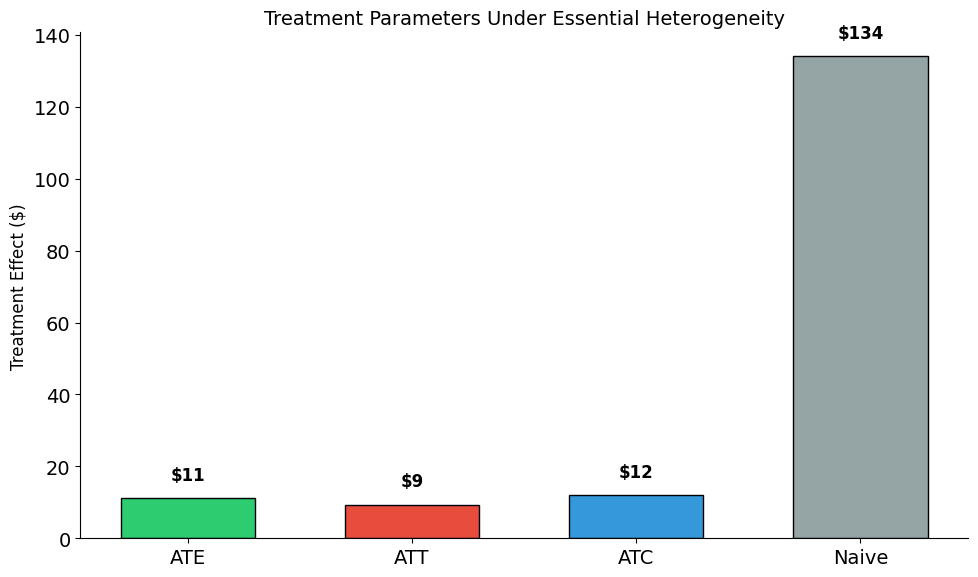

In [8]:
# Visualize treatment parameters
plot_treatment_parameters(
    ate=effects["ate"],
    att=effects["att"],
    atc=effects["atc"],
    naive=effects["naive_estimate"],
    title="Treatment Parameters Under Essential Heterogeneity",
)
plt.show()

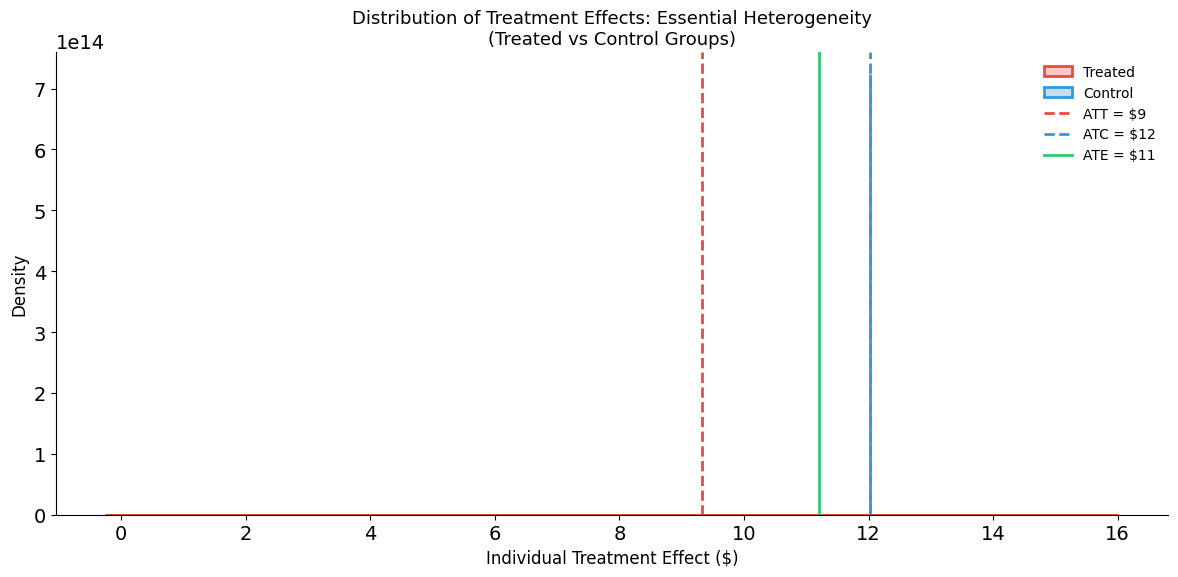

In [9]:
# Show distribution of treatment effects by treatment status
plot_treatment_effects_distribution(df, treatment_col="D")
plt.show()

## 5. MTE-Style Analysis: How Effects Vary with Selection

Using quality score as a proxy for selection propensity (high quality = more likely to be treated), we can trace out how the marginal treatment effect varies.

In [10]:
# Compute MTE by quality bins
mte_df = compute_mte_by_quality(df, quality_col="quality_score", n_bins=5)

print("MTE by Quality Bin")
print("=" * 60)
for _, row in mte_df.iterrows():
    print(
        f"Quality {row['quality_min']:.1f}-{row['quality_max']:.1f}: "
        f"MTE = ${row['mte']:>8,.0f}, "
        f"Treated = {row['pct_treated']:>5.1%}, "
        f"N = {row['n_products']:>3.0f}"
    )

print("\n-> MTE decreases with quality (selection propensity)")
print("   High-quality products are selected but benefit LESS")

MTE by Quality Bin
Quality 2.8-5.0: MTE = $      11, Treated = 30.0%, N = 500

-> MTE decreases with quality (selection propensity)
   High-quality products are selected but benefit LESS


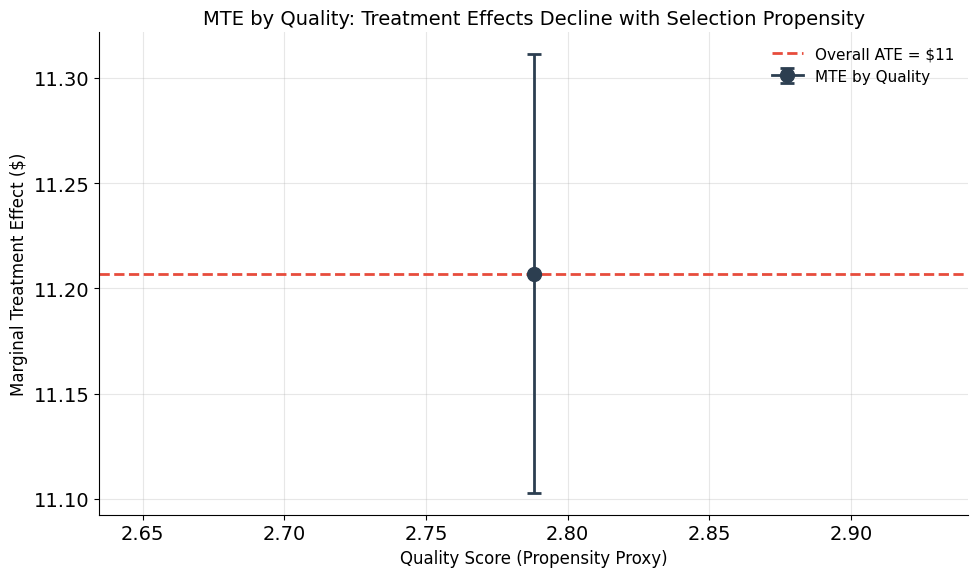

In [11]:
# Plot MTE curve
plot_mte_by_quality(mte_df, title="MTE by Quality: Treatment Effects Decline with Selection Propensity")
plt.show()

## 6. Visualizing the Selection Mechanism

Let's see how quality relates to both selection and treatment effects.

/home/peisenha/office/business/eisenhauer-io/courses/business-decisions/docs/source/measure-impact/03-generalized-roy-model/support.py:502: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


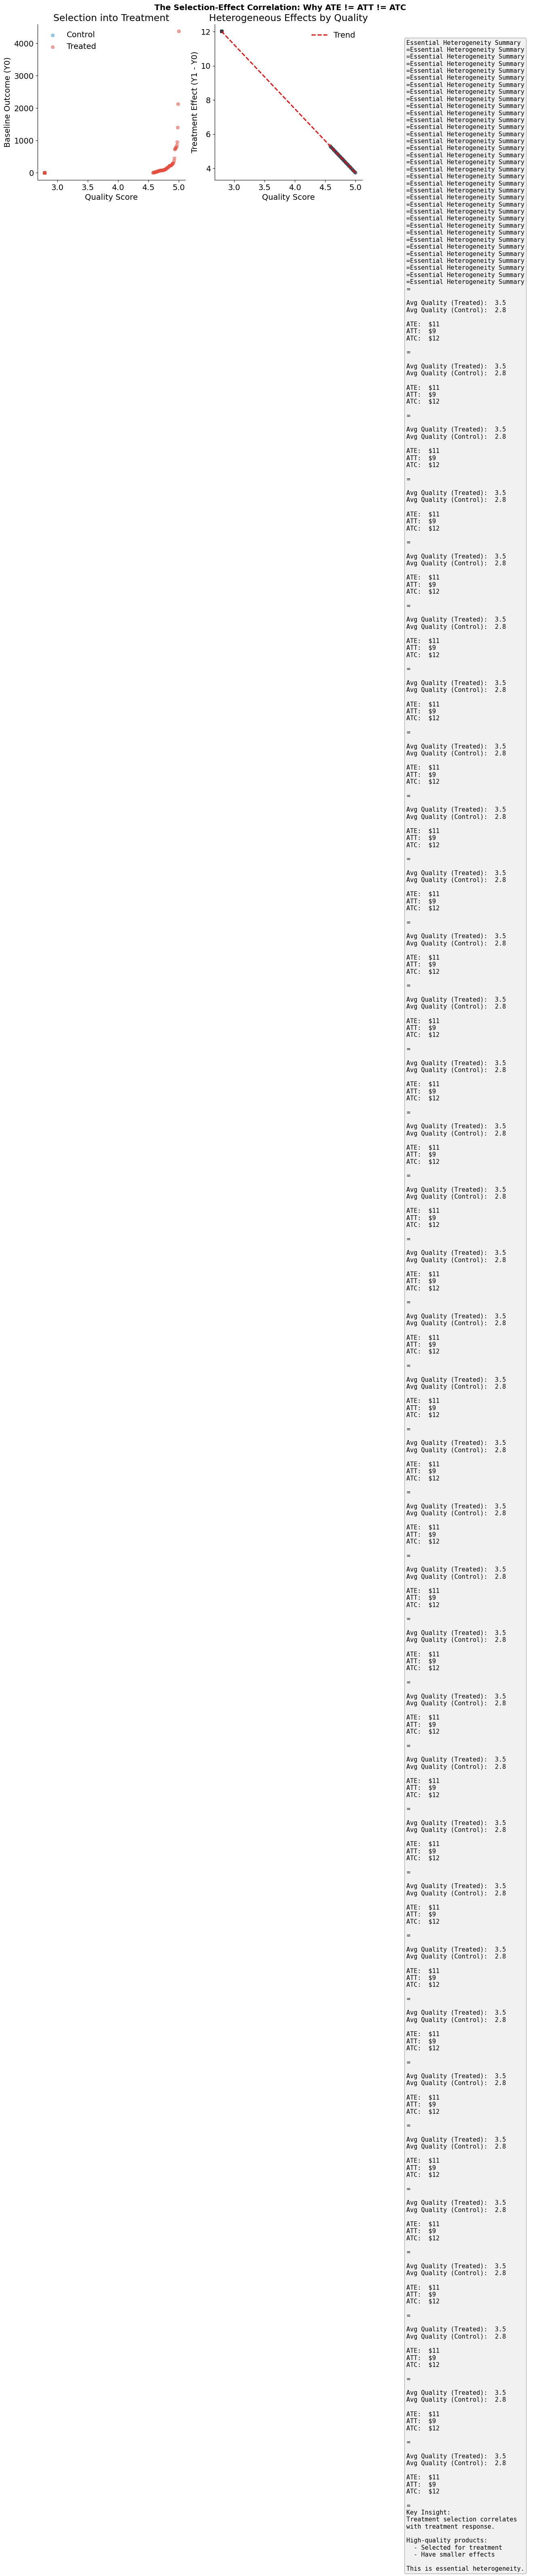

In [12]:
# Three-panel visualization of selection mechanism
plot_selection_mechanism(df, quality_col="quality_score", treatment_col="D")
plt.show()

## 7. Bias Decomposition

Now we decompose the naive estimate into its components to understand what drives the bias.

In [13]:
# Compute bias decomposition
decomp = compute_bias_decomposition(df, treatment_col="D")

print("Bias Decomposition")
print("=" * 60)
print(f"Naive Estimate:                       ${decomp['naive_estimate']:>10,.2f}")
print(f"True ATE:                             ${decomp['ate']:>10,.2f}")
print(f"Baseline Bias (selection on Y0):      ${decomp['baseline_bias']:>10,.2f}")
print(f"Selection on Gains (ATT - ATE):       ${decomp['selection_on_gains']:>10,.2f}")
print(f"Total Bias:                           ${decomp['total_bias']:>10,.2f}")
print("\nVerification:")
print("  Naive = ATE + Baseline + SelGains")
print(
    f"  {decomp['naive_estimate']:.2f} = {decomp['ate']:.2f} + "
    f"{decomp['baseline_bias']:.2f} + {decomp['selection_on_gains']:.2f}"
)

Bias Decomposition
Naive Estimate:                       $    134.01
True ATE:                             $     11.21
Baseline Bias (selection on Y0):      $    124.69
Selection on Gains (ATT - ATE):       $     -1.89
Total Bias:                           $    122.80

Verification:
  Naive = ATE + Baseline + SelGains
  134.01 = 11.21 + 124.69 + -1.89


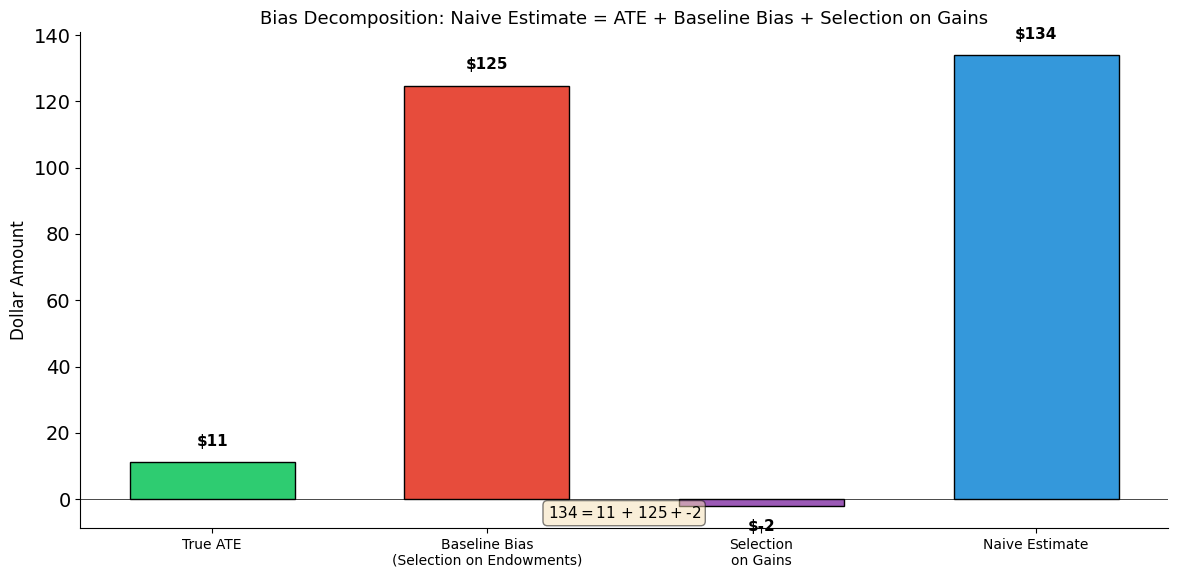

In [14]:
# Visualize bias decomposition
plot_bias_decomposition(decomp)
plt.show()

## 8. Interpretation

### What We Observe

| Component | Value | Interpretation |
|-----------|-------|----------------|
| **Baseline Bias** | Positive | High-quality products have higher $Y_0$ (they sell more even without treatment) |
| **Selection on Gains** | Negative | High-quality products have smaller $\delta$ (less room for improvement) |
| **Net Effect** | Depends | The two bias components partially offset each other |

### Key Insights

1. **ATE ≠ ATT ≠ ATC**: Under essential heterogeneity, these parameters diverge

2. **Naive comparisons are biased**: Simply comparing treated vs. control conflates the true effect with selection

3. **Understanding selection matters**: The MTE framework reveals how effects vary with selection propensity

4. **Policy implications**: 
   - If we expand treatment, we treat products with higher marginal effects (ATC > ATT)
   - The naive estimate doesn't tell us what to expect from policy changes

In [15]:
# Print comprehensive summary
print_essential_heterogeneity_summary(df, treatment_col="D")

ESSENTIAL HETEROGENEITY ANALYSIS

Treatment Parameters:
  ATE (Average Treatment Effect):     $     11.21
  ATT (Treatment on Treated):         $      9.32
  ATC (Treatment on Control):         $     12.02

Bias Decomposition:
  Naive Estimate:                     $    134.01
  True ATE:                           $     11.21
  Baseline Bias (selection on Y0):    $    124.69
  Selection on Gains (ATT - ATE):     $     -1.89
  Total Bias:                         $    122.80

Verification:
  Naive = ATE + Baseline + SelGains
  134.01 = 11.21 + 124.69 + -1.89


## Summary

This lecture demonstrated **essential heterogeneity** using an e-commerce content optimization example:

### Theory
- Treatment effects vary across individuals (heterogeneity)
- Selection into treatment correlates with treatment response (essential heterogeneity)
- This causes ATE, ATT, and ATC to diverge

### Application
- High-quality products are selected for content optimization
- But high-quality products benefit LESS from optimization (diminishing returns)
- This creates negative selection on gains: ATT < ATE

### Bias Decomposition
- **Baseline bias** (positive): Treated products have higher baseline outcomes
- **Selection on gains** (negative): Treated products have smaller treatment effects
- These partially offset, but the naive estimate still doesn't equal the ATE

### Implications
Understanding essential heterogeneity is crucial for:
- Correctly interpreting treatment effect estimates
- Predicting effects of policy changes (expanding or restricting treatment)
- Designing optimal targeting strategies